# 1. 코드

In [1]:
import os
import cv2
import numpy as np
import urllib
import tarfile

from glob import glob
from matplotlib import pyplot as plt
import tensorflow as tf
from IPython.display import Image

In [2]:
# segmentation으로 사람 분리하기
# semantic segmentation : '사람'이라는 추상적인 정보를 이미지에서 추출하는 방법, 그래서 사람이 누구인지 관계없이 같은 라벨로 표현됨.
# 모델 종류 : FCN, SegNet, U-Net, DeepLab 등
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 tf 입력으로 사용가능한 shape의 numpy array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    # segmentation 실행
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]

        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory : ', model_dir)

# 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드
# 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX+'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz', download_path)

temp directory :  /home/ssac14/aiffel/human_segmentation/models


In [4]:
img_dir = os.getenv('HOME') + '/aiffel/human_segmentation/images'
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [5]:
class PortraitMode:
    def __init__(self, img, target):
        self.img = img
        img_path = os.path.join(img_dir, img)
        self.img_orig = cv2.imread(img_path)
        self.MODEL = DeepLabModel(download_path)
        self.img_resized, self.seg_map = self.MODEL.run(self.img_orig)
#         print(self.img_orig.shape, self.img_resized.shape, self.seg_map.max())
        self.target = [LABEL_NAMES.index(x)for x in target]
        self.img_bg, self.img_mask_color = self.specific_area()
#         print(self.img_bg.shape, self.img_mask_color.shape)
        
    def specific_area(self):
        # 특정 영역 추출
        img_show = self.img_resized.copy()
        seg_map = np.where(np.isin(self.seg_map, self.target), self.seg_map, 0)  # 예측 중 target만 추출 - target 외 예측은 0으로 만듬, 그럼 예측된 seg이미지(map)은 최대값이 15가 된다.
        img_mask = seg_map * (255/seg_map.max())  # 255 normalization - seg맵에 표현된 값을 원본 이미지에 그림형태로 출력하기위해 255로 정규화
        img_mask = img_mask.astype(np.uint8)
        
        # segmentation 결과 원래 크기로 복원
        img_mask_up = cv2.resize(img_mask, self.img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
        
        # 배경이미지 얻기
        img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)    # 이미지 반전 - 배경 255, 사람 0
        img_bg = cv2.bitwise_and(self.img_orig, img_bg_mask)  # 배경만 있는 영상 얻기
        return img_bg, img_mask_color
    
    def blur(self):
        # 배경 흐리게 하기
        img_bg_blur = cv2.blur(self.img_bg, (13, 13))
        
        # 흐린 배경과 원본 영상 합성
        img_concat = np.where(self.img_mask_color==255, self.img_orig, img_bg_blur)
        
        # 이미지 저장
        new_name = 'blur_' + self.img
        new_path = os.path.join(img_dir, new_name)
        cv2.imwrite(new_path, img_concat)
        
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    
    def chromakey(self):
        # 배경이미지 사이즈 맞춰주기
        w, h, c = self.img_orig.shape
        img_bg_path = os.path.join(img_dir, 'bg.png')
        img_bg = cv2.imread(img_bg_path)
        img_bg_resized = cv2.resize(img_bg, dsize=(h, w), interpolation=cv2.INTER_AREA)

        img_concat = np.where(self.img_mask_color==255, self.img_orig, img_bg_resized)
        
        # 이미지 저장
        new_name = 'chromakey_' + self.img
        new_path = os.path.join(img_dir, new_name)
        cv2.imwrite(new_path, img_concat)
        
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()

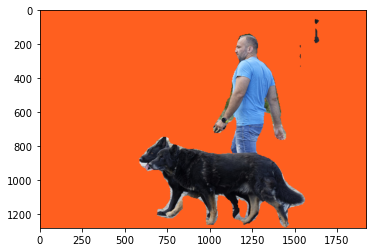

In [6]:
img1 = PortraitMode('person_dog.jpg', ['person', 'dog'])
img1.chromakey()

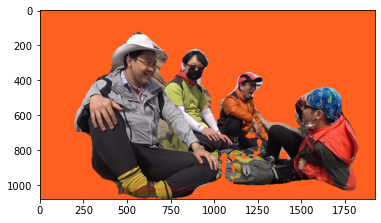

In [7]:
img2 = PortraitMode('person_7.png', ['person'])
img2.chromakey()

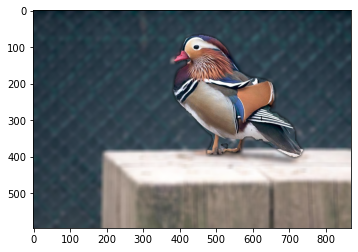

In [8]:
img3 = PortraitMode('bird.jpg', ['bird'])
img3.blur()

<br><br><br><br><br><br>

# 2. 문제점

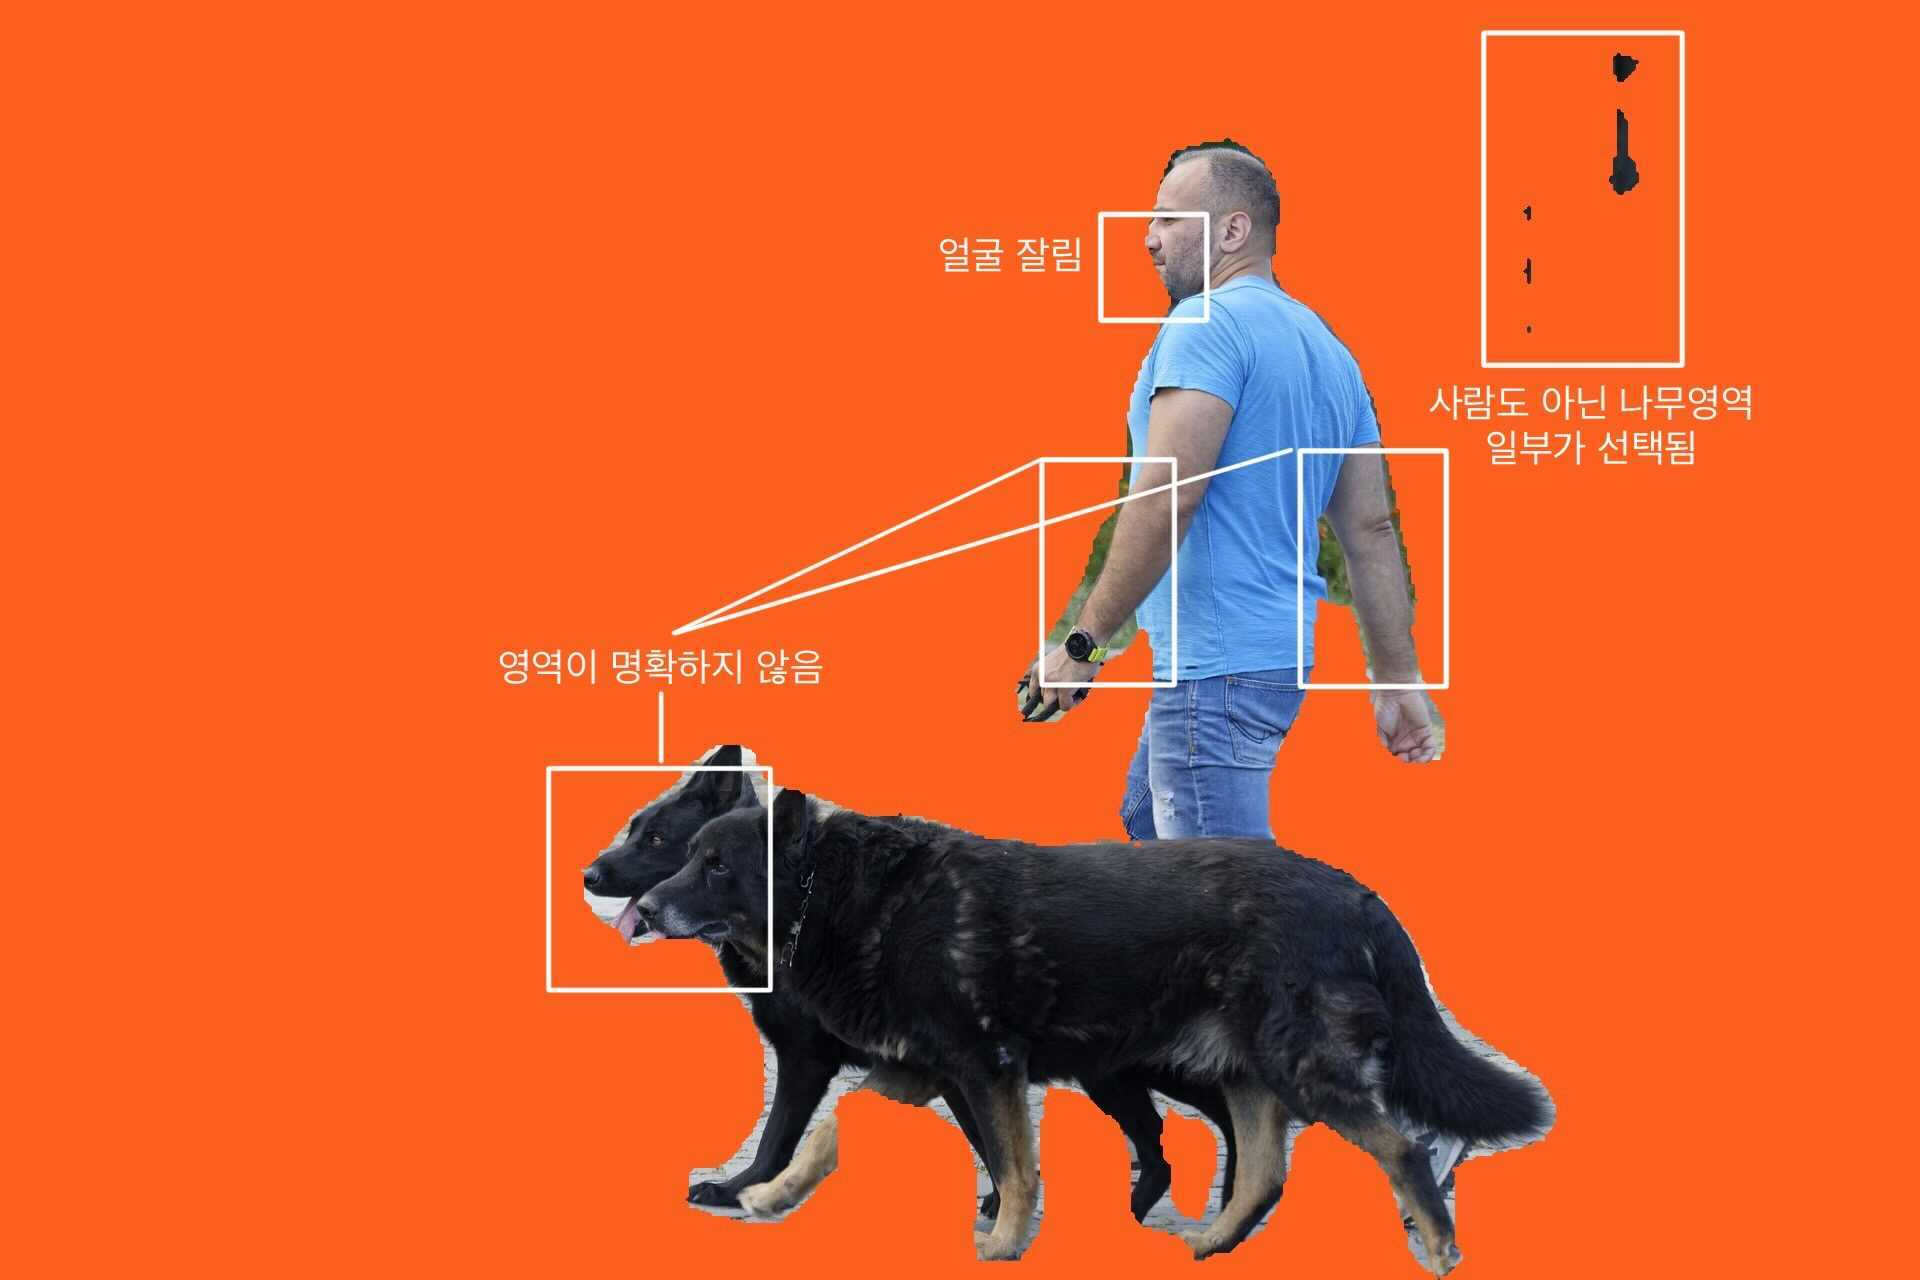

In [9]:
pb_1 = os.path.join(img_dir, 'pb1.jpg')
Image(pb_1, width = 600)

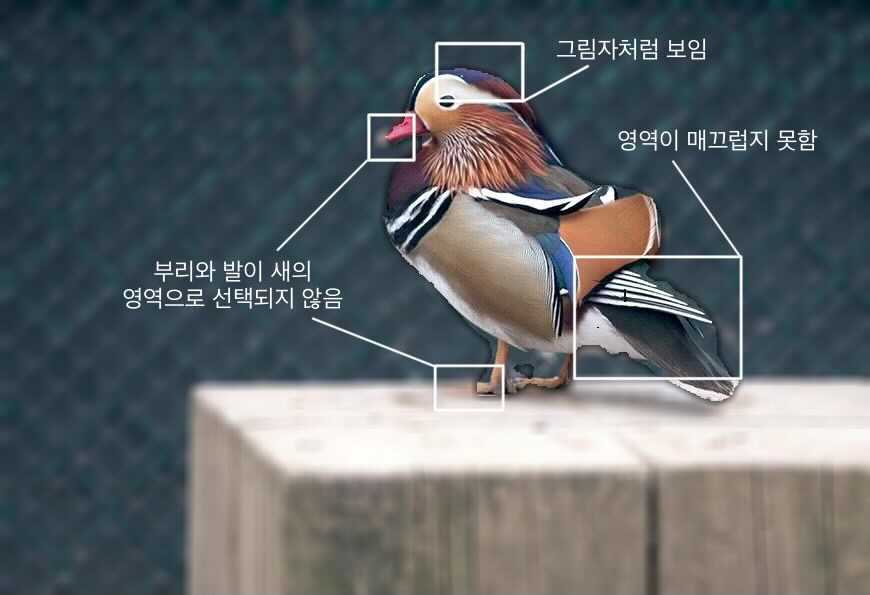

In [10]:
pb_2 = os.path.join(img_dir, 'pb2.jpg')
Image(pb_2, width = 600)

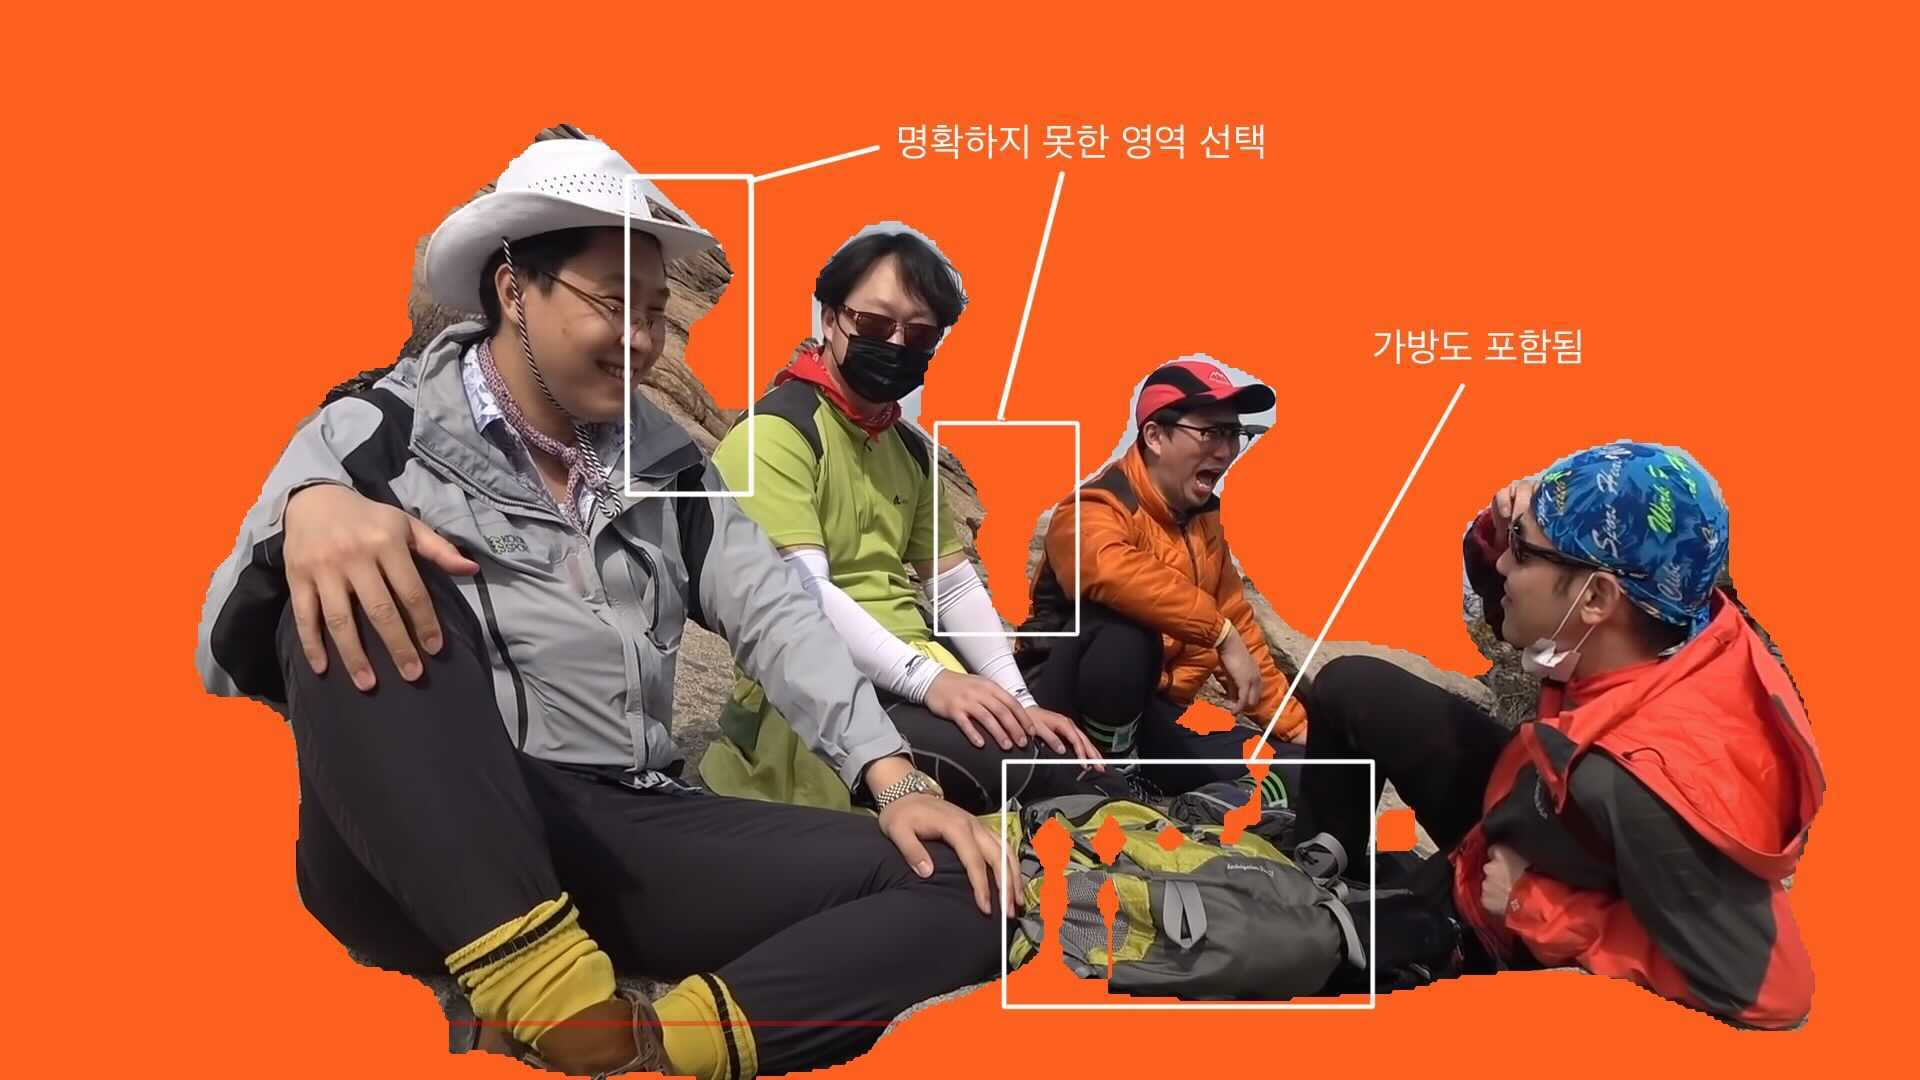

In [11]:
pb_3 = os.path.join(img_dir, 'pb3.jpg')
Image(pb_3, width = 600)

<br><br><br><br><br><br>

# 3. 해결방법

## 3-1. blur부분의 검정그림자
배경이미지를 분리하면서 detection된 영역이 검정으로 바뀐 배경이미지가 같이 블러처리되었기 때문에 그림자가 진 것처럼 보이게 된 것 같다.
원본이미지를 복사하여 블러처리한 후 배경영역으로 선택된 부분만 살려두고 그 외(실제 detection된 영역 ex.사람)는 잘라버린(255) 후 다시 merge하면 될 것 같다.

## 3-2. 경계가 명확하지 못한 부분
**1) output stride**  
검색해보니 output stride라는 용어에 대해서 알게 되었다. output stride는 input 이미지의 해상도와 (global pooling하기 전)output 해상도의 비율로 정의되며, 최종 feature map이 input image에 비해 32배 줄었다면 output stride는 32가 되는 것이다. 보통 image classification의 마지막 feature map은 input보다 32배정도 해상도가 줄어들지만, sementic segmentation에서는 더욱 디테일한 정보를 얻어내기 위해 더 빡빡한 feature map이 필요하기 때문에 마지막 부분의 block을 1개 혹은 2개를 삭제 후 Atrous convolution해줌으로써 output stride를 16 혹은 8로 줄인다고 한다.  
참고 : https://kuklife.tistory.com/121

**2) PointRend**  
참고 논문에 소개되는 DeepLabV3는 디코딩 시 4배 업샘플링을 2회 실시하기 위해, 16배로 업샘플링을 하게 된다. 그러나 segmentation은 픽셀 단위로 세분화하는 작업이기 때문에 한 번에 대량의 업샘플링을 수행하면 분류 정확도가 떨어지고, 특히 선의 얇은 경계선이 거칠어진다고 한다. 그래서 facebook이 제안하는 pointrend는 **특징량 맵의 픽셀 값의 분포에 따라 계산 대상을 선택하는 샘플링의 밀도를 바꾸는 것**으로, 필요한 픽셀로 필요한 계산을 하고 미세 조정할 수 있다. 그래서 상세한 라벨링이 가능하여 테두리의 분류 정확도가 높아진다고 한다.    
참고 : https://arxiv.org/abs/1912.08193


<br><br><br><br><br><br>

# 회고
### 이번 프로젝트에서 **어려웠던 점**
deeplab v3+ 모델의 구조를 잘 이해하지 못해서 문제점을 파악하기가 더 어려웠고, 특히나 encoder, decoder부분이 잘 이해가지 않았다. 


### 만약에 루브릭 평가 관련 지표를 **달성하지 못했을 때, 이유에 관한 추정**.
우선적으로 여러 방안을 찾아보던 중 output stride, pointrend 두 방안에서 말하는 문제점은 encoder, decoder에 충분한 feature들을 잡지 못한다거나 잃어버리는 등 유사한 문제점을 제시했다. 이 부분에서 좀 더 생각해보고 추론해볼 수 있을 것 같다.


### 자기 다짐
생각보다 여러 방안들을 실제로 찾아보니 재밌었지만, 이 부분을 막상 적용해보려고 하니 잘 되지 않았고, 기존 코드에서 어떤 부분을 수정하면 좋을지 약간 막막했다. 역시나 코드를 많이 쳐보고 다른 사람들의 코드를 많이 봐야할 것 같다.